# Simple Armed-Bandit Learning Algorithms

By: Isaac Edem Adoboe - [ieadoboe - GitHub](https://github.com/ieadoboe)


Goal: Compare performance in terms of

1. the average per-step reward and
2. the proportion of time the optimal action (highest expected reward)


### Setup


In [47]:
# import necessary libraries
import jax
import jax.numpy as jnp
import jax.random as random
from jax import jit, vmap

import numpy as np
import matplotlib.pyplot as plt

# Stationary Reward Distribution


#### True Means vs Rewards

The true means in reality are hidden and cannot be directly observed. Rewards are what we see.


In [98]:
# set random number generator for reproducibility
key = random.PRNGKey(123)


# Create bandit environment - k-armed bandit means from N(0,1)
def create_bandit_testbed(key, k=10):
    return random.normal(key, (k,))


# True means
key, subkey = random.split(key)
true_means = create_bandit_testbed(key=subkey)
print(f"True means (aka ground truth):\n {true_means}")

print(
    f"\nOptimal arm: {jnp.argmax(true_means)} (mean = {jnp.max(true_means):.3f}) (actually the {jnp.argmax(true_means)+1}th arm)"
)

True means (aka ground truth):
 [-0.5154414  -0.89756405  1.9826834  -1.9789759  -2.8818078  -0.662635
 -0.03326578 -0.1879544  -0.6107877   0.16164331]

Optimal arm: 2 (mean = 1.983) (actually the 3th arm)


In this problem, we assume they never change hence we use this true means for all 2000 time steps.


In [88]:
# Define the reward function from N(mu, 1)
def get_reward(key, arm, true_means):
    return random.normal(key) + true_means[arm]


# test the reward function
rewards = get_reward(key, 4, true_means)
print(f"Reward from pulling arm 4: {rewards}")

Reward from pulling arm 4: -3.0030150413513184


# Testing different algorithms


## Pure Greedy Bandit


In [89]:
# Greedy with non-optimistic initial values
def greedy_bandit(key, true_means, n_steps=2000):
    k = len(true_means)

    # Initialize Q values with non-optimistic initial values (zeros)
    Q = jnp.zeros(k)
    action_counts = jnp.zeros(k)

    # Initialize rewards
    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Find the optimal arm (highest mean)
    optimal_arm = jnp.argmax(true_means)

    for step in range(n_steps):
        key, subkey = random.split(key)  # for arm selection

        # Find arms with the highest Q value
        max_q = jnp.max(Q)
        best_arms = jnp.where(Q == max_q)[0]

        # Random tie-breaker among best arms
        chosen_arm = random.choice(subkey, best_arms)

        # Get reward for chosen arm
        key, subkey = random.split(key)  # for reward generation
        reward = random.normal(subkey) + true_means[chosen_arm]

        # Update Q value for chosen arm
        action_counts = action_counts.at[chosen_arm].add(1)
        n = action_counts[chosen_arm]

        Q = Q.at[chosen_arm].add((reward - Q[chosen_arm]) / n)

        # update results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q, action_counts

In [90]:
def plot_performance_comparison(rewards, optimal_actions, true_means, window_size=50):
    """
    Plot algorithm performance vs optimal performance over time
    """
    n_steps = len(rewards)
    optimal_reward = jnp.max(true_means)

    # Calculate moving averages
    def moving_average(data, window):
        return jnp.convolve(data, jnp.ones(window) / window, mode="valid")

    # Cumulative average reward
    cumulative_avg_reward = jnp.cumsum(rewards) / jnp.arange(1, n_steps + 1)

    # Moving average reward
    moving_avg_reward = moving_average(rewards, window_size)

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Cumulative Average Reward vs Optimal
    ax1.plot(cumulative_avg_reward, "blue", linewidth=2, label="Algorithm Performance")
    ax1.axhline(
        y=optimal_reward,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Optimal ({optimal_reward:.3f})",
    )
    ax1.fill_between(
        range(n_steps),
        cumulative_avg_reward,
        optimal_reward,
        alpha=0.2,
        color="red",
        label="Performance Gap",
    )
    ax1.set_title("Cumulative Average Reward vs Optimal", fontsize=14)
    ax1.set_xlabel("Time Step")
    ax1.set_ylabel("Average Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Moving Average Reward vs Optimal
    steps_ma = range(window_size - 1, n_steps)
    ax2.plot(
        steps_ma,
        moving_avg_reward,
        "blue",
        linewidth=2,
        label=f"Algorithm ({window_size}-step avg)",
    )
    ax2.axhline(
        y=optimal_reward,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Optimal ({optimal_reward:.3f})",
    )
    ax2.fill_between(
        steps_ma,
        moving_avg_reward,
        optimal_reward,
        alpha=0.2,
        color="red",
        label="Performance Gap",
    )
    ax2.set_title(
        f"Moving Average Reward ({window_size} steps) vs Optimal", fontsize=14
    )
    ax2.set_xlabel("Time Step")
    ax2.set_ylabel("Average Reward")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    final_performance = cumulative_avg_reward[-1]
    final_gap = optimal_reward - final_performance
    final_optimal_pct = jnp.mean(optimal_actions[-100:]) * 100

    print(f"\n PERFORMANCE SUMMARY")
    print(f"{'='*50}")
    print(f"Optimal reward per step:     {optimal_reward:.4f}")
    print(f"Algorithm's final avg:       {final_performance:.4f}")
    print(
        f"Performance gap:             {final_gap:.4f} ({final_gap/optimal_reward*100:.1f}%)"
    )
    print(f"Final optimality rate:       {final_optimal_pct:.1f}% (last 100 steps)")
    print(f"Efficiency:                  {final_performance/optimal_reward*100:.1f}%")

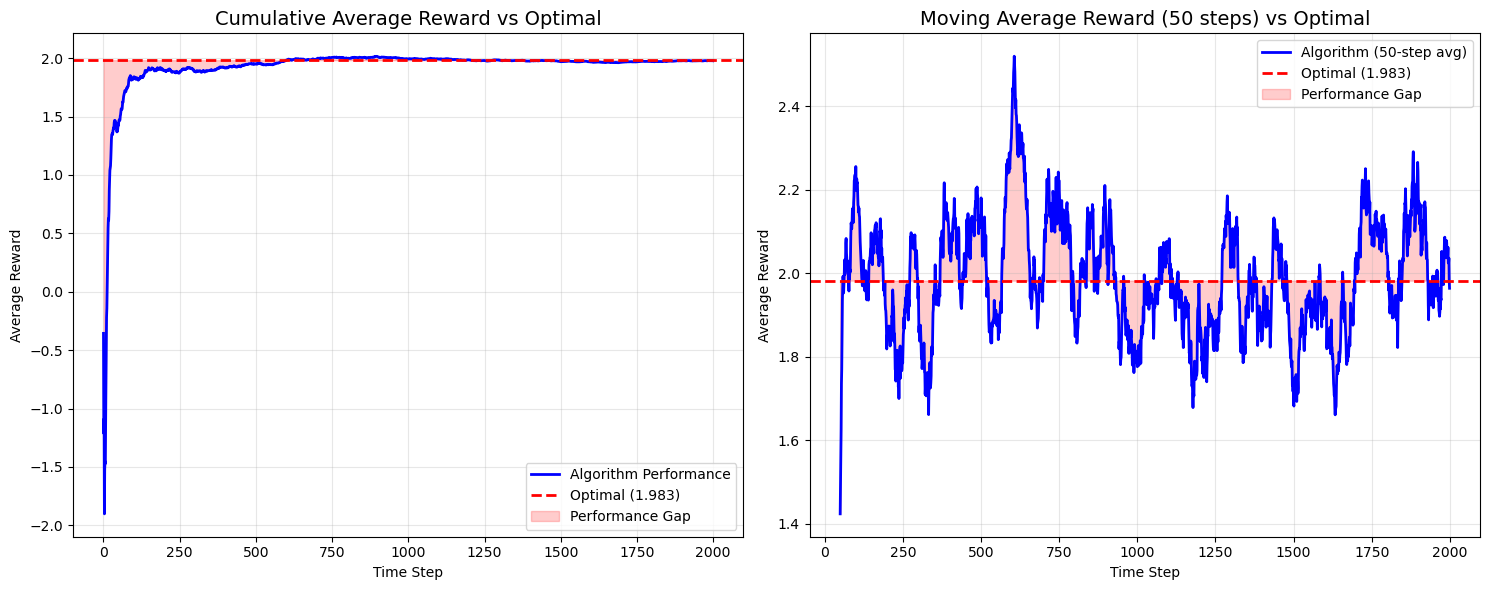


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9778
Performance gap:             0.0048 (0.2%)
Final optimality rate:       100.0% (last 100 steps)
Efficiency:                  99.8%


In [95]:
key, subkey = random.split(key)
rewards_1, optimal_actions_1, Q_1, counts_1 = greedy_bandit(subkey, true_means)

plot_performance_comparison(rewards_1, optimal_actions_1, true_means)

## Epsilon-Greedy Bandit


In [54]:
def epsilon_greedy_bandit(key, true_means, epsilon, n_steps=2000):
    k = len(true_means)

    # Initialize Q values with non-optimistic initial values (zeros)
    Q = jnp.zeros(k)
    action_counts = jnp.zeros(k)

    # Initialize rewards
    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Find the optimal arm (highest mean)
    optimal_arm = jnp.argmax(true_means)

    for step in range(n_steps):
        key, subkey = random.split(key)

        # EPSILON-GREEDY ACTION SELECTION
        if random.uniform(subkey) < epsilon:
            # EXPLORE: Choose random arm
            key, subkey = random.split(key)
            chosen_arm = random.randint(subkey, (1,), 0, k)[0]
        else:
            # EXPLOIT: Choose greedy arm (with random tiebreaking)
            max_q = jnp.max(Q)
            best_arms = jnp.where(Q == max_q)[0]
            key, subkey = random.split(key)
            chosen_arm = random.choice(subkey, best_arms)

        # Get reward for chosen arm
        key, subkey = random.split(key)
        reward = random.normal(subkey) + true_means[chosen_arm]

        # Update Q value for chosen arm (same as greedy)
        action_counts = action_counts.at[chosen_arm].add(1)
        n = action_counts[chosen_arm]
        Q = Q.at[chosen_arm].add((reward - Q[chosen_arm]) / n)

        # update results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q, action_counts

### Manually testing different $\epsilon$ values


### $\epsilon$ = 0.1


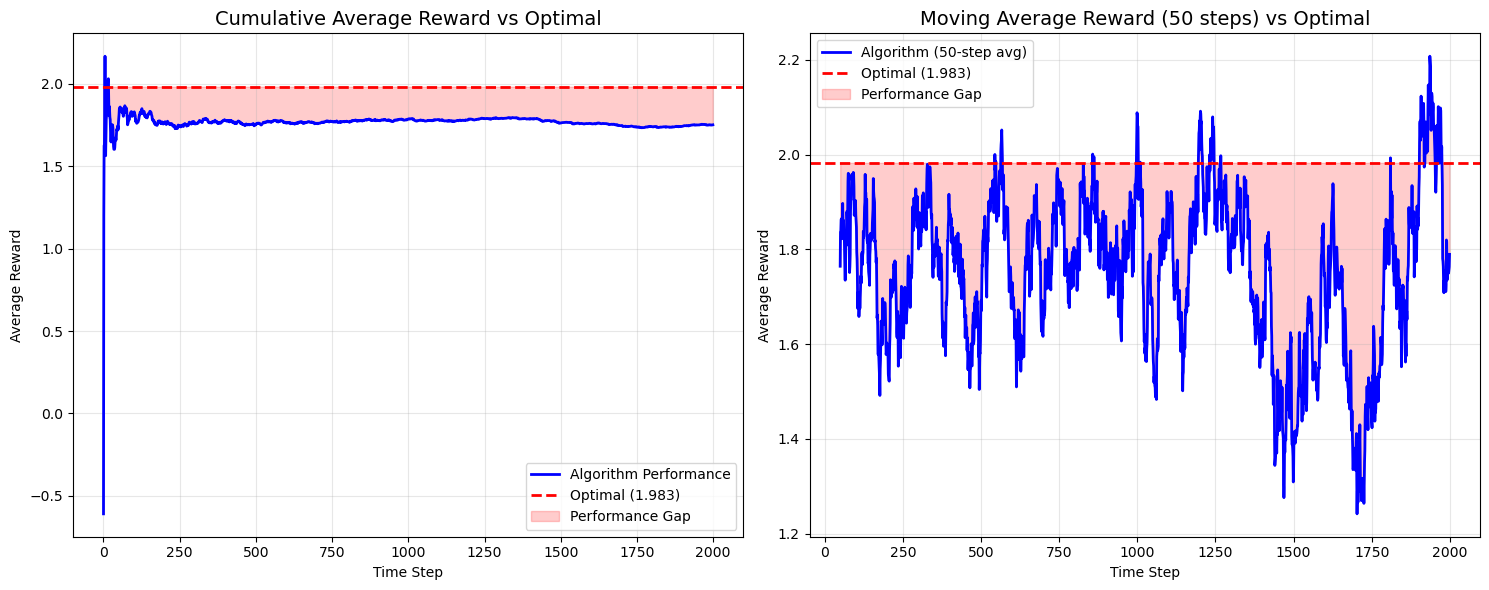


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.7514
Performance gap:             0.2313 (11.7%)
Final optimality rate:       94.0% (last 100 steps)
Efficiency:                  88.3%


In [99]:
key, subkey = random.split(key)

rewards_2, optimal_actions_2, Q_2, counts_2 = epsilon_greedy_bandit(
    key, true_means, epsilon=0.1
)

plot_performance_comparison(rewards_2, optimal_actions_2, true_means)

### $\epsilon$ = 0.3


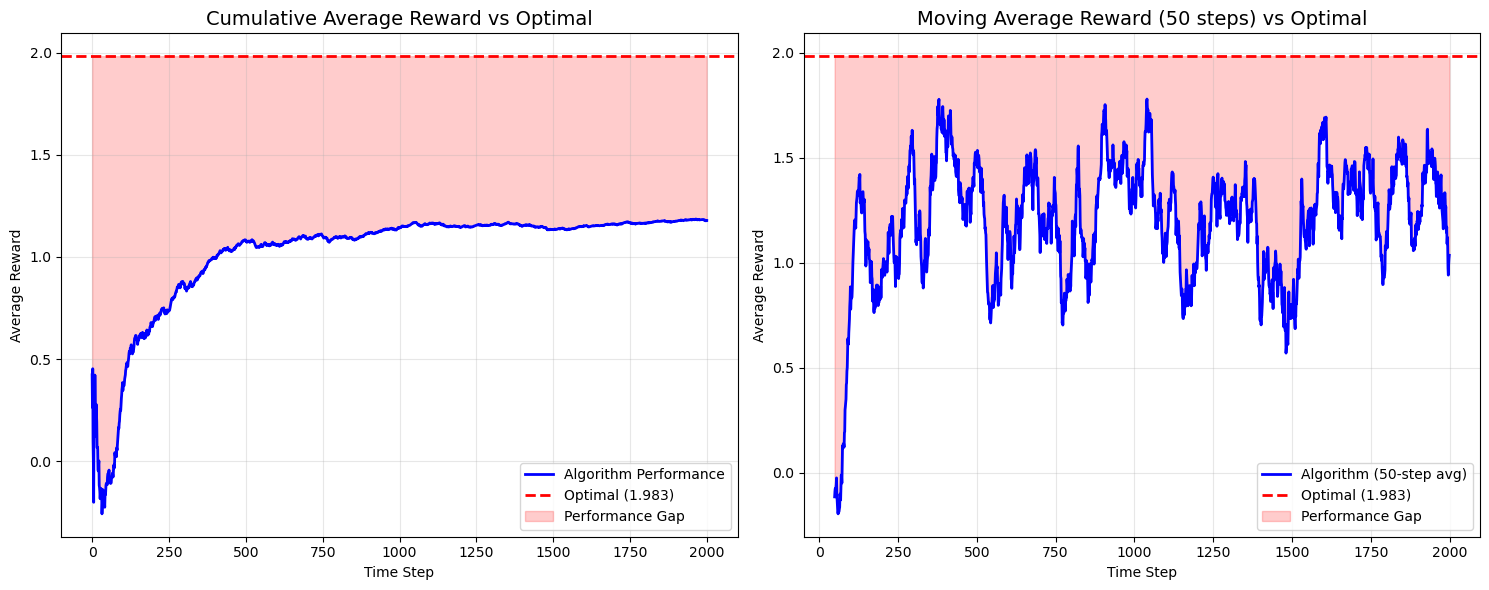


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.1789
Performance gap:             0.8038 (40.5%)
Final optimality rate:       73.0% (last 100 steps)
Efficiency:                  59.5%


In [100]:
key, subkey = random.split(key)

rewards_2, optimal_actions_2, Q_2, counts_2 = epsilon_greedy_bandit(
    key, true_means, epsilon=0.3
)

plot_performance_comparison(rewards_2, optimal_actions_2, true_means)

Even manually, we find that, the bandit performance degrades significantly at epsilon of 0.3 and struggles to bounce back.


### $\epsilon$ = 0.5


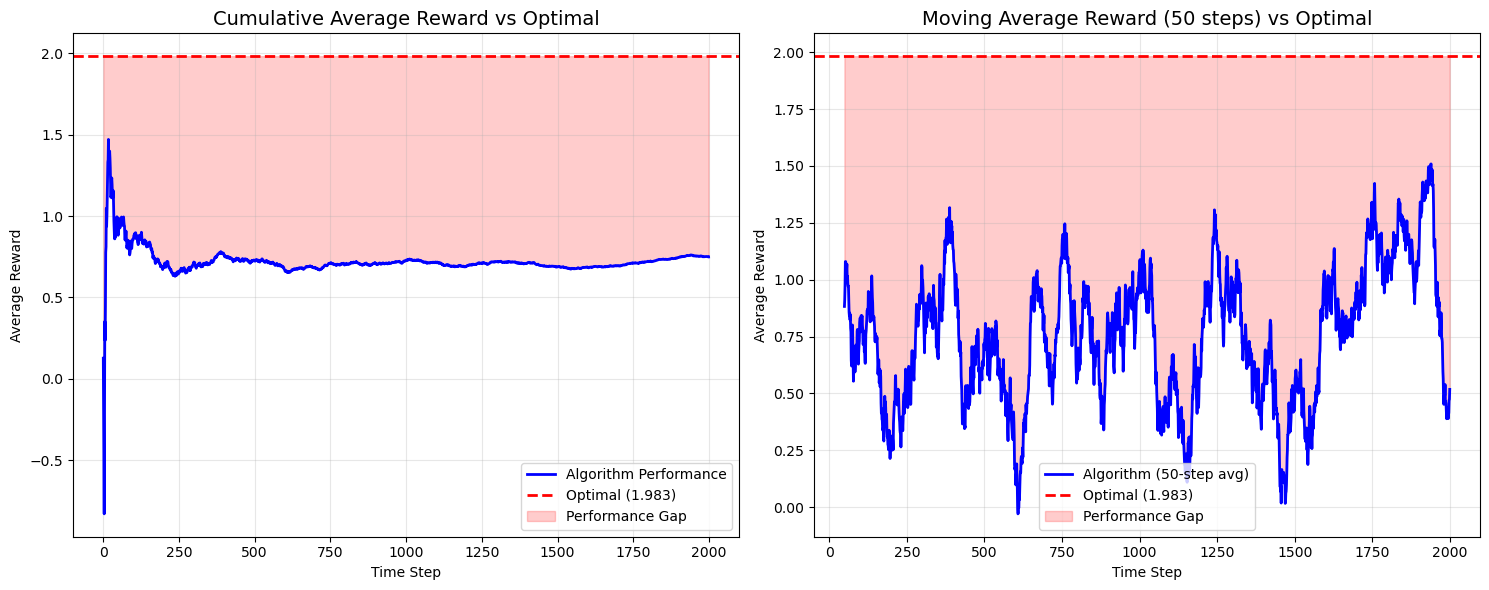


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       0.7493
Performance gap:             1.2334 (62.2%)
Final optimality rate:       59.0% (last 100 steps)
Efficiency:                  37.8%


In [101]:
key, subkey = random.split(key)

rewards_2, optimal_actions_2, Q_2, counts_2 = epsilon_greedy_bandit(
    key, true_means, epsilon=0.5
)

plot_performance_comparison(rewards_2, optimal_actions_2, true_means)

## Choosing an appropriate episilon value with Pilot Runs


In [102]:
def tune_epsilon_with_pilots(
    key,
    true_means,
    epsilon_candidates=[
        0.01,
        0.05,
        0.1,
        0.2,
        0.3,
    ],  # based on the results of the previous manual experimentation we cap the epsilon values at 0.3
    pilot_steps=500,
    pilot_runs=10,
):
    results = {}

    for eps in epsilon_candidates:
        print(f"\nTesting epsilon = {eps}")
        pilot_rewards = []
        pilot_optimality = []

        for run in range(pilot_runs):
            key, subkey = random.split(key)
            rewards, optimal_actions, _, _ = epsilon_greedy_bandit(
                subkey, true_means, eps, n_steps=pilot_steps
            )

            # performance metrics
            final_avg_reward = jnp.mean(rewards[-100:])  # last 100 steps
            final_optimality = jnp.mean(optimal_actions[-100:])

            pilot_rewards.append(final_avg_reward)
            pilot_optimality.append(final_optimality)

        # store results
        avg_reward = jnp.mean(jnp.array(pilot_rewards))
        avg_optimality = jnp.mean(jnp.array(pilot_optimality))

        results[eps] = {
            "avg_reward": avg_reward,
            "avg_optimality": avg_optimality,
            "std_reward": jnp.std(jnp.array(pilot_rewards)),
        }

        print(f"  Avg reward: {avg_reward:.4f} ± {results[eps]['std_reward']:.4f}")
        print(f"  Optimality: {avg_optimality:.1%}")

    # Select best epsilon (highest average reward)
    best_eps = max(results.keys(), key=lambda x: results[x]["avg_reward"])

    print(
        f"\n Best epsilon = {best_eps} (avg reward: {results[best_eps]['avg_reward']:.4f})"
    )
    return best_eps, results

In [103]:
key, subkey = random.split(key)
best_epsilon, pilot_results = tune_epsilon_with_pilots(subkey, true_means)


Testing epsilon = 0.01
  Avg reward: 1.9409 ± 0.3025
  Optimality: 94.3%

Testing epsilon = 0.05
  Avg reward: 1.9014 ± 0.1090
  Optimality: 96.0%

Testing epsilon = 0.1
  Avg reward: 1.6969 ± 0.1248
  Optimality: 91.1%

Testing epsilon = 0.2
  Avg reward: 1.4663 ± 0.1454
  Optimality: 82.9%

Testing epsilon = 0.3
  Avg reward: 1.1732 ± 0.1429
  Optimality: 74.0%

 Best epsilon = 0.01 (avg reward: 1.9409)


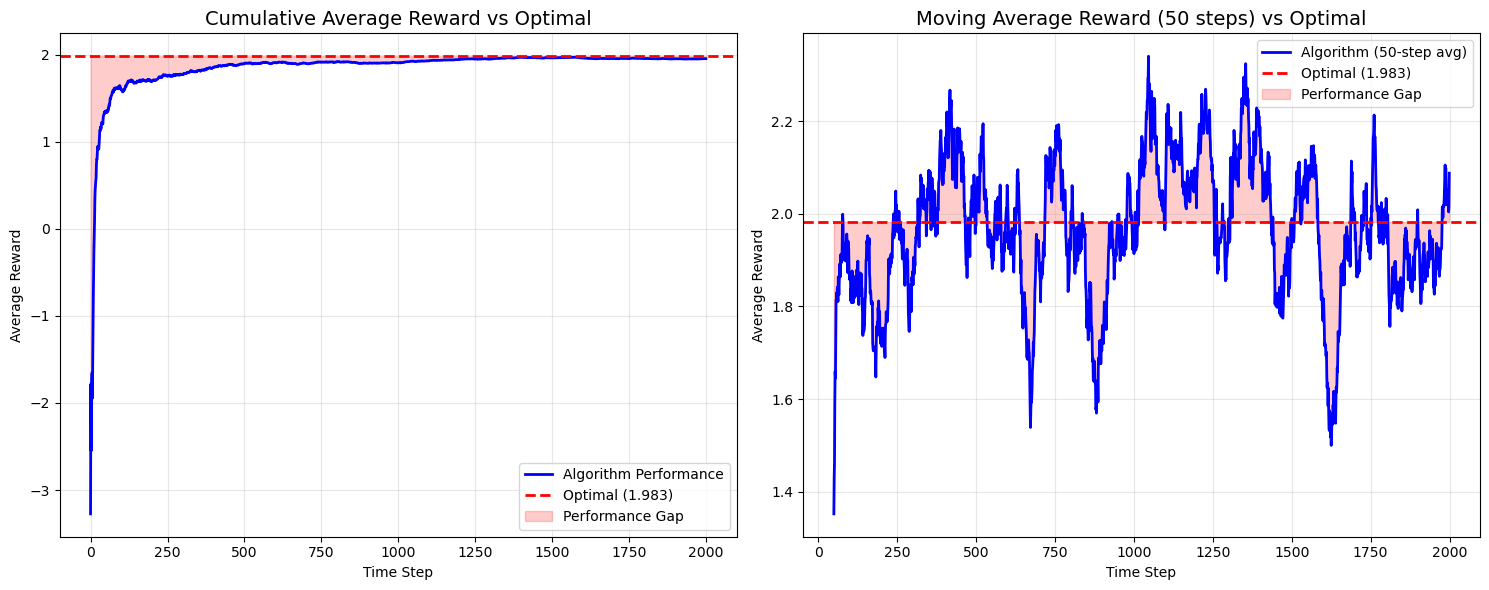


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9546
Performance gap:             0.0281 (1.4%)
Final optimality rate:       99.0% (last 100 steps)
Efficiency:                  98.6%


In [107]:
# Run epsilon-greedy with best epsilon
key, subkey = random.split(key)
rewards, optimal_actions, Q, counts = epsilon_greedy_bandit(
    subkey, true_means, best_epsilon, n_steps=2000
)

plot_performance_comparison(rewards, optimal_actions, true_means)

We notice that at most of epsilon values tested range between 70-96% efficiency. An epsilon of 0.01 provides us with the closest value (1.9409) to the true (hidden) mean (1.983).


## Optimistic Greedy Bandit


In [69]:
def optimistic_greedy_bandit(key, true_means, n_steps=2000):
    k = len(true_means)

    # initialise optimistic value
    max_true_mean = jnp.max(true_means)
    optimistic_value = max_true_mean + 2.576  # 99.5th percentile ≈ 2.576

    # Initialize ALL Q-values to this optimistic value
    Q = jnp.full(k, optimistic_value)
    action_counts = jnp.zeros(k)

    # Initialize rewards
    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Find the optimal arm (highest mean)
    optimal_arm = jnp.argmax(true_means)

    for step in range(n_steps):
        key, subkey = random.split(key)

        # GREEDY ACTION SELECTION
        max_q = jnp.max(Q)
        best_arms = jnp.where(Q == max_q)[0]
        chosen_arm = random.choice(subkey, best_arms)

        # Get reward for chosen arm
        key, subkey = random.split(key)
        reward = random.normal(subkey) + true_means[chosen_arm]

        # Update Q value for chosen arm
        action_counts = action_counts.at[chosen_arm].add(1)
        n = action_counts[chosen_arm]
        Q = Q.at[chosen_arm].add((reward - Q[chosen_arm]) / n)

        # update results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q, action_counts

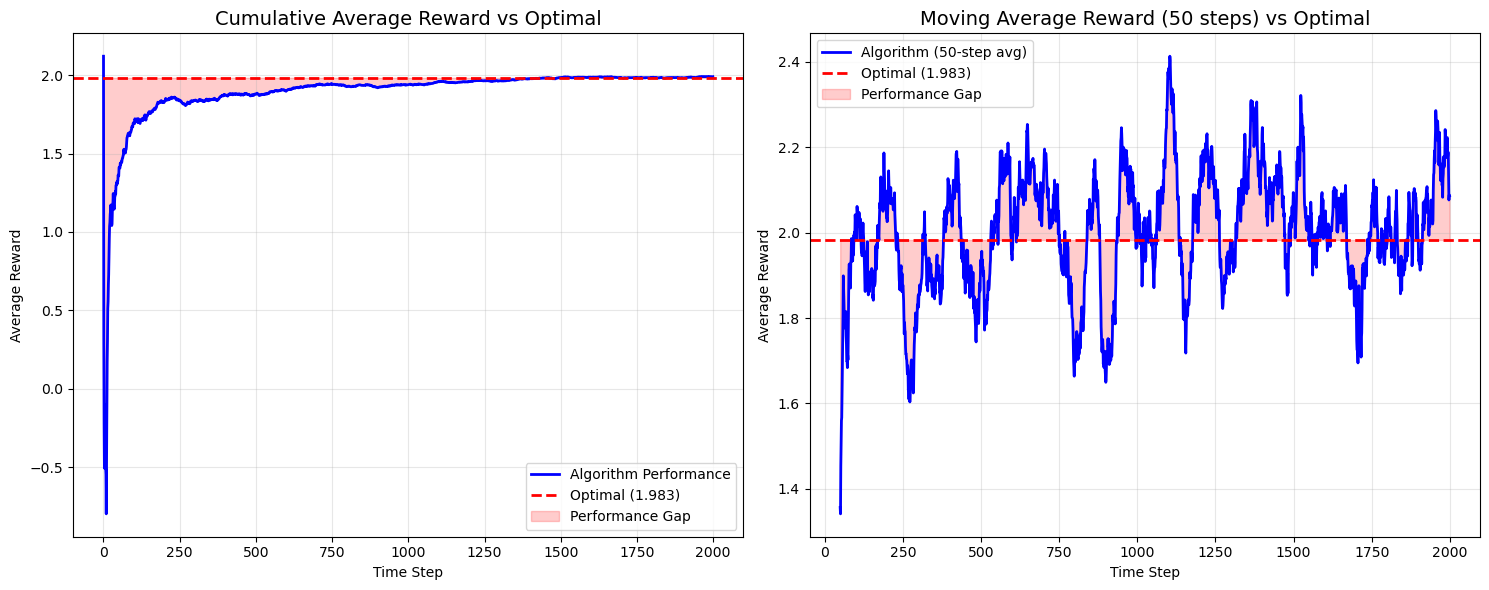


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9899
Performance gap:             -0.0073 (-0.4%)
Final optimality rate:       100.0% (last 100 steps)
Efficiency:                  100.4%


In [104]:
key, subkey = random.split(key)

rewards_3, optimal_actions_3, Q_3, counts_3 = optimistic_greedy_bandit(key, true_means)

plot_performance_comparison(rewards_3, optimal_actions_3, true_means)

## (Alpha) Gradient Bandit


In [62]:
def gradient_bandit(key, true_means, alpha, n_steps=2000):
    k = len(true_means)

    # Initialize preferences -all actions equally preferred
    Q = jnp.zeros(k)  # Action preferences

    # Track results
    rewards = jnp.zeros(n_steps)
    optimal_actions = jnp.zeros(n_steps, dtype=bool)

    # Find optimal arm
    optimal_arm = jnp.argmax(true_means)

    # Running average reward (baseline)
    avg_reward = 0.0

    for step in range(n_steps):
        key, subkey = random.split(key)

        # softmax action selection
        # convert preferences to probabilities: π_t(a) = exp(H_t(a)) / Σ exp(H_t(b))
        # subtract max for numerical stability
        Q_stable = Q - jnp.max(Q)
        exp_Q = jnp.exp(Q_stable)
        action_probs = exp_Q / jnp.sum(exp_Q)

        # Sample action according to probabilities
        chosen_arm = random.choice(subkey, k, p=action_probs)

        # Get reward for chosen arm
        key, subkey = random.split(key)
        reward = random.normal(subkey) + true_means[chosen_arm]

        # update preferences using gradient ascent
        # Baseline: running average reward
        if step == 0:
            avg_reward = reward
        else:
            avg_reward = avg_reward + (reward - avg_reward) / (step + 1)

        # Gradient update
        reward_diff = reward - avg_reward

        # Update all preferences
        for a in range(k):
            if a == chosen_arm:
                # Chosen action: H_t+1(A_t) = H_t(A_t) + alpha(R_t - R_bar_t)(1 - π_t(A_t))
                Q = Q.at[a].add(alpha * reward_diff * (1 - action_probs[a]))
            else:
                # Other actions: H_t+1(a) = H_t(a) - alpha(R_t - R_bar_t)π_t(a)
                Q = Q.at[a].add(-alpha * reward_diff * action_probs[a])

        # Track results
        rewards = rewards.at[step].set(reward)
        optimal_actions = optimal_actions.at[step].set(chosen_arm == optimal_arm)

    return rewards, optimal_actions, Q, action_probs

### Manually testing different $\alpha$ values


### $\alpha$ = 0.1


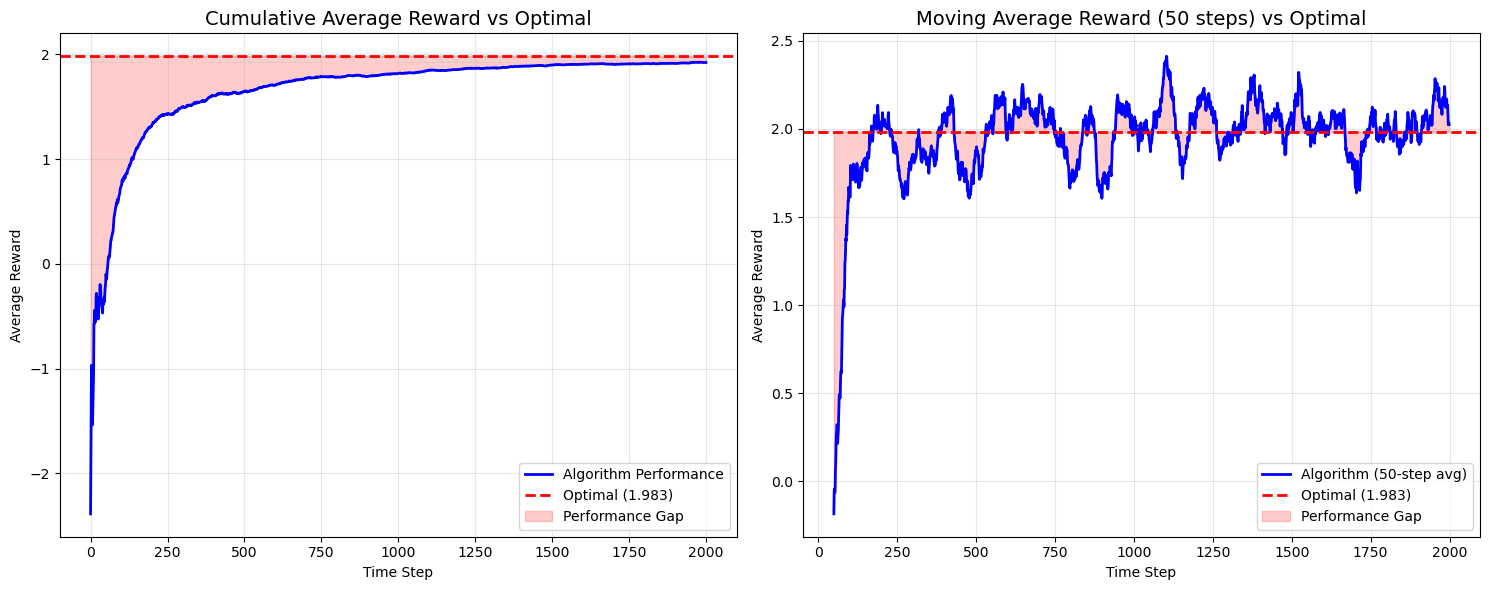


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9229
Performance gap:             0.0597 (3.0%)
Final optimality rate:       99.0% (last 100 steps)
Efficiency:                  97.0%


In [106]:
key, subkey = random.split(key)

rewards_4, optimal_actions_4, Q_4, counts_4 = gradient_bandit(
    key, true_means, alpha=0.1
)

plot_performance_comparison(rewards_4, optimal_actions_4, true_means)

### $\alpha$ = 0.2


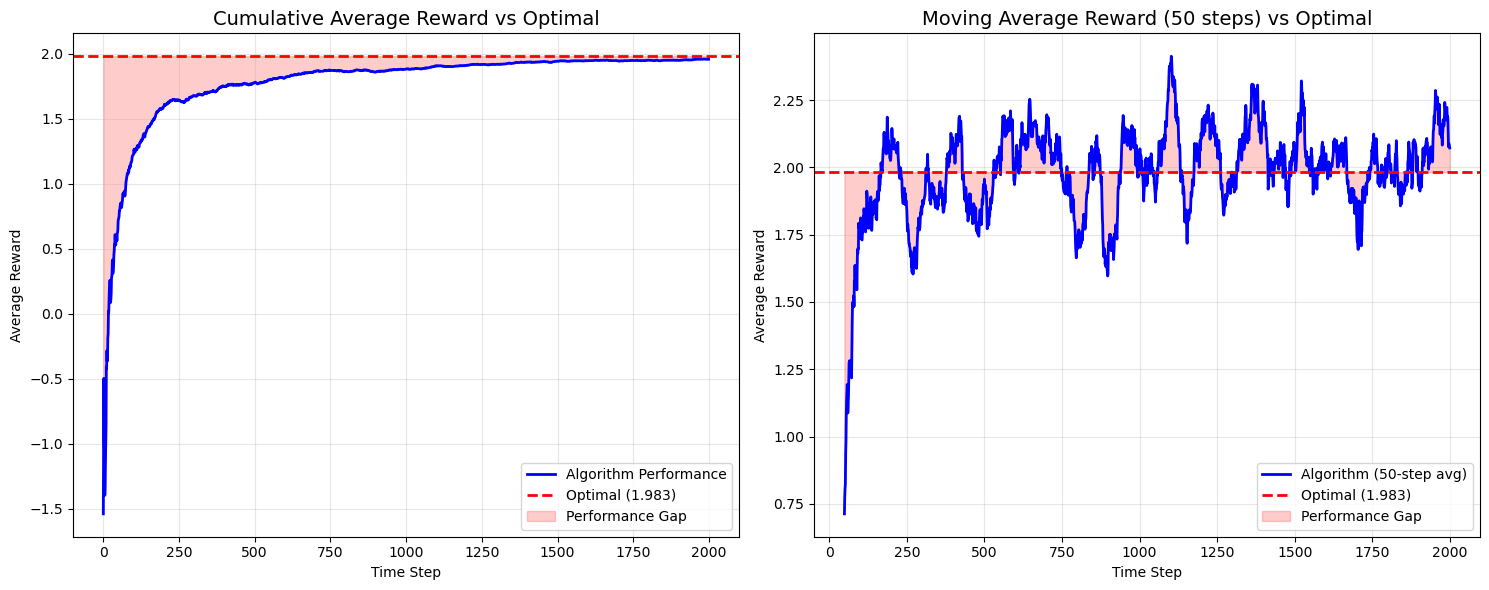


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9595
Performance gap:             0.0232 (1.2%)
Final optimality rate:       100.0% (last 100 steps)
Efficiency:                  98.8%


In [108]:
key, subkey = random.split(key)

rewards_4, optimal_actions_4, Q_4, counts_4 = gradient_bandit(
    key, true_means, alpha=0.2
)

plot_performance_comparison(rewards_4, optimal_actions_4, true_means)

### $\alpha$ = 0.3


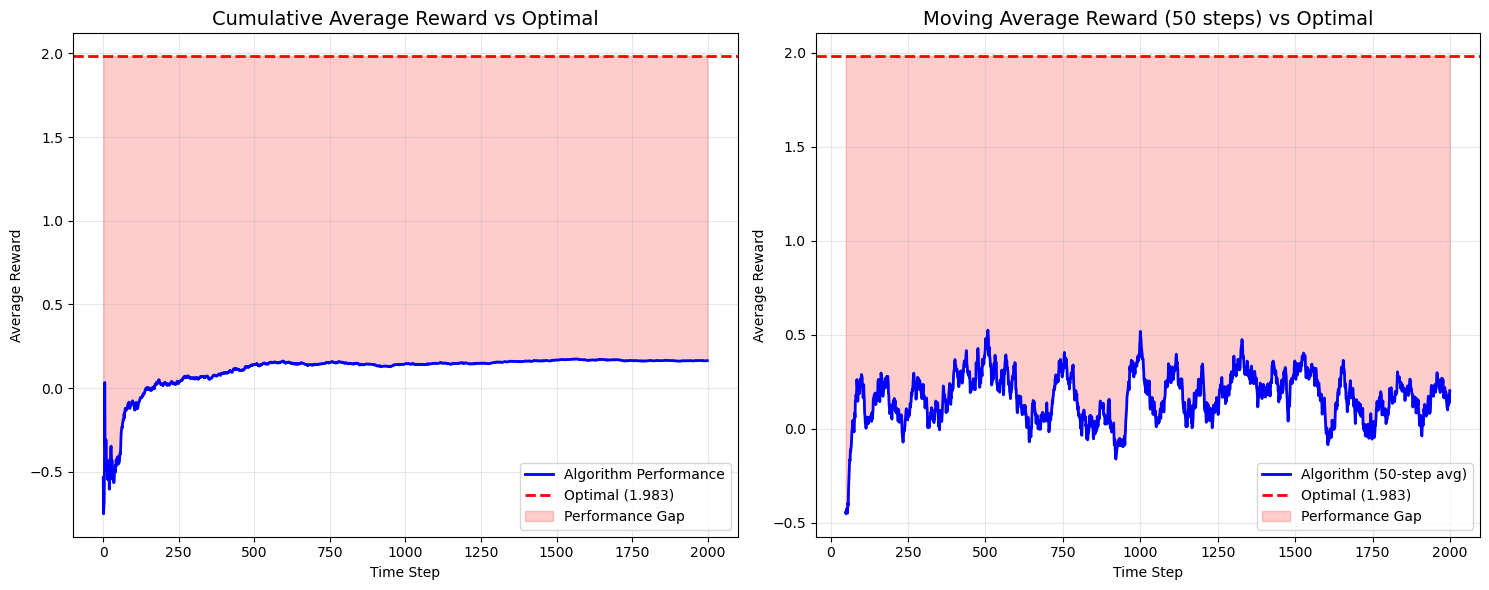


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       0.1645
Performance gap:             1.8182 (91.7%)
Final optimality rate:       1.0% (last 100 steps)
Efficiency:                  8.3%


In [109]:
key, subkey = random.split(key)

rewards_4, optimal_actions_4, Q_4, counts_4 = gradient_bandit(
    key, true_means, alpha=0.3
)

plot_performance_comparison(rewards_4, optimal_actions_4, true_means)

## Choosing an appropriate alpha value with Pilot Runs


In [111]:
def tune_alpha_with_pilots(
    key,
    true_means,
    alpha_candidates=[
        0.01,
        0.05,
        0.1,
        0.2,
        0.3,
    ],  # based on the results of the previous manual experimentation we cap the alpha values at 0.3
    pilot_steps=500,
    pilot_runs=10,
):
    results = {}

    for alpha in alpha_candidates:
        print(f"\nTesting alpha = {alpha}")
        pilot_rewards = []
        pilot_optimality = []

        for run in range(pilot_runs):
            key, subkey = random.split(key)
            rewards, optimal_actions, _, _ = gradient_bandit(
                subkey, true_means, alpha, n_steps=pilot_steps
            )

            # performance metrics
            final_avg_reward = jnp.mean(rewards[-100:])  # last 100 steps
            final_optimality = jnp.mean(optimal_actions[-100:])

            pilot_rewards.append(final_avg_reward)
            pilot_optimality.append(final_optimality)

        # store results
        avg_reward = jnp.mean(jnp.array(pilot_rewards))
        avg_optimality = jnp.mean(jnp.array(pilot_optimality))

        results[alpha] = {
            "avg_reward": avg_reward,
            "avg_optimality": avg_optimality,
            "std_reward": jnp.std(jnp.array(pilot_rewards)),
        }

        print(f"  Avg reward: {avg_reward:.4f} ± {results[alpha]['std_reward']:.4f}")
        print(f"  Optimality: {avg_optimality:.1%}")

    # Select best alpha (highest average reward)
    best_alpha = max(results.keys(), key=lambda x: results[x]["avg_reward"])

    print(
        f"\n Best alpha = {best_alpha} (avg reward: {results[best_alpha]['avg_reward']:.4f})"
    )
    return best_alpha, results

In [112]:
key, subkey = random.split(key)
best_alpha, pilot_results = tune_alpha_with_pilots(subkey, true_means)


Testing alpha = 0.01
  Avg reward: 0.7809 ± 0.2498
  Optimality: 53.4%

Testing alpha = 0.05
  Avg reward: 1.9597 ± 0.0753
  Optimality: 97.5%

Testing alpha = 0.1
  Avg reward: 1.9876 ± 0.1481
  Optimality: 99.1%

Testing alpha = 0.2
  Avg reward: 1.9853 ± 0.1231
  Optimality: 99.6%

Testing alpha = 0.3
  Avg reward: 1.9757 ± 0.1195
  Optimality: 99.8%

 Best alpha = 0.1 (avg reward: 1.9876)


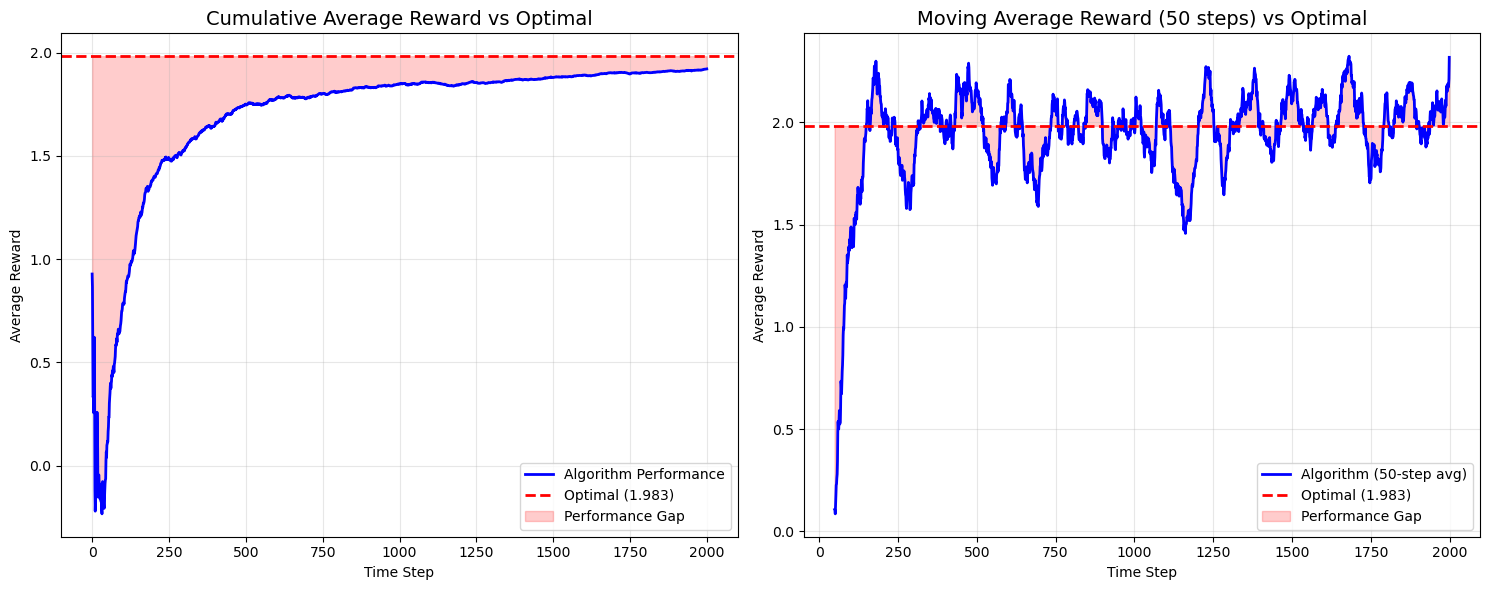


 PERFORMANCE SUMMARY
Optimal reward per step:     1.9827
Algorithm's final avg:       1.9212
Performance gap:             0.0615 (3.1%)
Final optimality rate:       99.0% (last 100 steps)
Efficiency:                  96.9%


In [114]:
# Run epsilon-greedy with best epsilon
key, subkey = random.split(key)
rewards, optimal_actions, Q, counts = gradient_bandit(
    subkey, true_means, best_alpha, n_steps=2000
)

plot_performance_comparison(rewards, optimal_actions, true_means)

# Run 1000 Simulation


In [117]:
# Run a bandit algorithm for a single simulation
def run_bandit(key, algorithm_fn, true_means, **kwargs):
    rewards, optimal_actions, _, _ = algorithm_fn(key, true_means, **kwargs)
    return rewards, optimal_actions


# Run simulations
def run_simulation(
    algorithm_fn, algorithm_name, true_means, n_simulations=1000, **kwargs
):
    print(f"Running {algorithm_name} ({n_simulations} simulations)...")

    key = random.PRNGKey(123)  # for reproducibility

    all_rewards = []
    all_optimal_actions = []

    for i in range(n_simulations):
        key, subkey = random.split(key)
        rewards, optimal_actions, _, _ = algorithm_fn(subkey, true_means, **kwargs)
        all_rewards.append(rewards)
        all_optimal_actions.append(optimal_actions)

        # Progress indicator
        if (i + 1) % 100 == 0:
            print(f"  Completed {i + 1}/{n_simulations}")

    # Average rewards per step across all simulations
    avg_reward_per_step = jnp.mean(all_rewards, axis=0)

    # Percentage of optimal actions per step across all simulations
    avg_optimal_per_step = jnp.mean(all_optimal_actions, axis=0) * 100

    return (
        avg_reward_per_step,
        avg_optimal_per_step,
        jnp.array(all_rewards),
        jnp.array(all_optimal_actions),
    )

In [ ]:
greedy_rewards, greedy_optimal, greedy_avg_reward, greedy_avg_optimal = run_simulation(
    greedy_bandit, "Greedy", true_means, n_simulations=1000
)

Running Greedy (1000 simulations)...
  Completed 100/1000
  Completed 200/1000
  Completed 300/1000
  Completed 400/1000
  Completed 500/1000


In [ ]:
eps_rewards, eps_optimal, eps_avg_reward, eps_avg_optimal = run_simulation(
    epsilon_greedy_bandit,
    "Epsilon-Greedy",
    true_means,
    n_simulations=1000,
    epsilon=0.05,
)

In [ ]:
opt_rewards, opt_optimal, opt_avg_reward, opt_avg_optimal = run_simulation(
    optimistic_greedy_bandit, "Optimistic Greedy", true_means, n_simulations=1000
)

In [ ]:
grad_rewards, grad_optimal, grad_avg_reward, grad_avg_optimal = run_simulation(
    gradient_bandit, "Gradient Bandit", true_means, n_simulations=1000, alpha=0.1
)

## Compare performance


We can see how each algorithm's average reward evolves over the 2000 time steps, making it easy to compare their learning curves and final performance


In [ ]:
def plot_rewards_comparison(
    greedy_avg_reward, eps_avg_reward, opt_avg_reward, grad_avg_reward, true_means
):
    """Plot average rewards over time for all algorithms"""

    plt.figure(figsize=(12, 8))

    # Plot each algorithm
    plt.plot(greedy_avg_reward, label="Greedy", linewidth=2)
    plt.plot(eps_avg_reward, label="Epsilon-Greedy (epsilon=0.05)", linewidth=2)
    plt.plot(opt_avg_reward, label="Optimistic Greedy", linewidth=2)
    plt.plot(grad_avg_reward, label="Gradient Bandit (alpha=0.1)", linewidth=2)

    # optimal reward line
    optimal_reward = jnp.max(true_means)
    plt.axhline(
        y=optimal_reward,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Optimal ({optimal_reward:.3f})",
    )

    plt.title("Average Reward Over Time (1000 Simulations)", fontsize=14)
    plt.xlabel("Time Step")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
plot_rewards_comparison(
    greedy_avg_reward, eps_avg_reward, opt_avg_reward, grad_avg_reward, true_means
)

# Non-stationary Reward Distribution


## Gradual Changes


## Abrupt Changes
